# Binary-Class Tabular Model for Raisin Grains Identification Using Python and TensorFlow Decision Forests
### David Lowe
### May 10, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Raisin Grains Identification dataset is a binary-class modeling situation where we attempt to predict one of two possible outcomes.

INTRODUCTION: In this study, the research team developed a computerized vision system to classify two different varieties of raisin grown in Turkey. The dataset contains the measurements for 900 raisin grain images. The image further broke down into seven major morphological features for each grain of raisin.

ANALYSIS: The performance of the preliminary Random Forest model achieved an accuracy benchmark of 96.05% on the training dataset. When we applied the finalized model to the test dataset, the model achieved an accuracy score of 86.67%.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be suitable for modeling this dataset.

Dataset Used: Raisin Dataset

Dataset ML Model: Binary classification with numerical features

Dataset Reference: https://www.muratkoklu.com/datasets/

One source of potential performance benchmarks: https://doi.org/10.30855/gmbd.2020.03.03

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.AUC()]

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow version: 2.8.0
Found TensorFlow Decision Forests v0.2.4


In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
dataset_path = 'https://dainesanalytics.com/datasets/muratkoklu-raisin-grains-dataset/Raisin_Dataset.arff'
colNames = ['Area','Major_Axis_Length','Minor_Axis_Length','Eccentricity','Convex_Area','Extent','Perimeter','Class']
df_dataset_import = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False, skiprows=20)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

    Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area  \
0  87524         442.246011         253.291155      0.819738        90546   
1  75166         406.690687         243.032436      0.801805        78789   
2  90856         442.267048         266.328318      0.798354        93717   
3  45928         286.540559         208.760042      0.684989        47336   
4  79408         352.190770         290.827533      0.564011        81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  


In [9]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               900 non-null    int64  
 1   Major_Axis_Length  900 non-null    float64
 2   Minor_Axis_Length  900 non-null    float64
 3   Eccentricity       900 non-null    float64
 4   Convex_Area        900 non-null    int64  
 5   Extent             900 non-null    float64
 6   Perimeter          900 non-null    float64
 7   Class              900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [10]:
print(df_dataset_import.describe())

                Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
count     900.000000         900.000000         900.000000    900.000000   
mean    87804.127778         430.929950         254.488133      0.781542   
std     39002.111390         116.035121          49.988902      0.090318   
min     25387.000000         225.629541         143.710872      0.348730   
25%     59348.000000         345.442898         219.111126      0.741766   
50%     78902.000000         407.803951         247.848409      0.798846   
75%    105028.250000         494.187014         279.888575      0.842571   
max    235047.000000         997.291941         492.275279      0.962124   

         Convex_Area      Extent    Perimeter  
count     900.000000  900.000000   900.000000  
mean    91186.090000    0.699508  1165.906636  
std     40769.290132    0.053468   273.764315  
min     26139.000000    0.379856   619.074000  
25%     61513.250000    0.670869   966.410750  
50%     81651.000000    0.7

In [11]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Perimeter            0
Class                0
dtype: int64
Total number of NaN in the dataframe:  0


In [12]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Class').size())

Class
Besni      450
Kecimen    450
dtype: int64


### 1.d) Data Cleaning

In [13]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Class': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

    Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  Convex_Area  \
0  87524         442.246011         253.291155      0.819738        90546   
1  75166         406.690687         243.032436      0.801805        78789   
2  90856         442.267048         266.328318      0.798354        93717   
3  45928         286.540559         208.760042      0.684989        47336   
4  79408         352.190770         290.827533      0.564011        81463   

     Extent  Perimeter   target  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen  


In [14]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               900 non-null    int64  
 1   Major_Axis_Length  900 non-null    float64
 2   Minor_Axis_Length  900 non-null    float64
 3   Eccentricity       900 non-null    float64
 4   Convex_Area        900 non-null    int64  
 5   Extent             900 non-null    float64
 6   Perimeter          900 non-null    float64
 7   target             900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [15]:
print(df_dataset_import.describe())

                Area  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
count     900.000000         900.000000         900.000000    900.000000   
mean    87804.127778         430.929950         254.488133      0.781542   
std     39002.111390         116.035121          49.988902      0.090318   
min     25387.000000         225.629541         143.710872      0.348730   
25%     59348.000000         345.442898         219.111126      0.741766   
50%     78902.000000         407.803951         247.848409      0.798846   
75%    105028.250000         494.187014         279.888575      0.842571   
max    235047.000000         997.291941         492.275279      0.962124   

         Convex_Area      Extent    Perimeter  
count     900.000000  900.000000   900.000000  
mean    91186.090000    0.699508  1165.906636  
std     40769.290132    0.053468   273.764315  
min     26139.000000    0.379856   619.074000  
25%     61513.250000    0.670869   966.410750  
50%     81651.000000    0.7

In [16]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

Area                 0
Major_Axis_Length    0
Minor_Axis_Length    0
Eccentricity         0
Convex_Area          0
Extent               0
Perimeter            0
target               0
dtype: int64
Total number of NaN in the dataframe:  0


In [17]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Besni      450
Kecimen    450
dtype: int64


### 1.e) Splitting Data into Sets

In [18]:
# Split the data further into training and test datasets
df_dataset_train, df_dataset_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                     stratify=df_dataset_import['target'])
print("df_dataset_train.shape: {} df_dataset_test.shape: {}".format(df_dataset_train.shape, df_dataset_test.shape))

df_dataset_train.shape: (810, 8) df_dataset_test.shape: (90, 8)


In [19]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_train['target']
df_features_train = df_dataset_train.drop(['target'], axis=1)

print("df_dataset_train.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_train.shape, df_features_train.shape, df_target_train.shape))

df_dataset_train.shape: (810, 8) df_features_train.shape: (810, 7) df_target_train.shape: (810,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

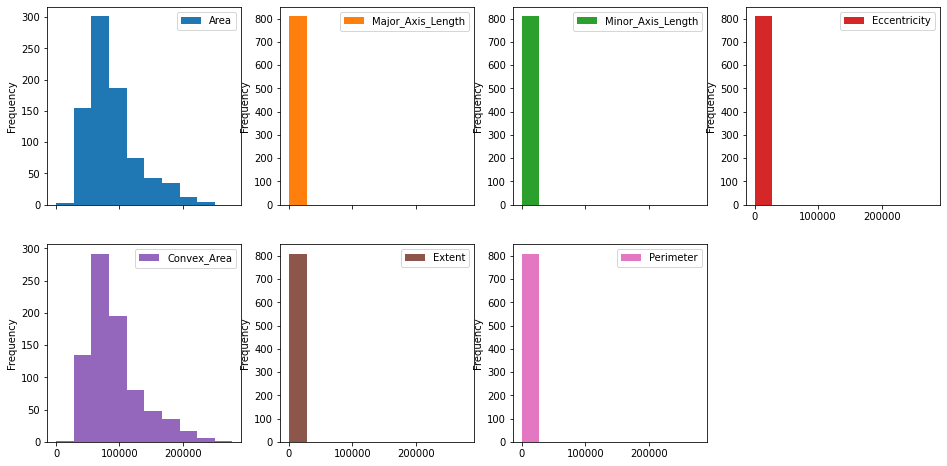

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

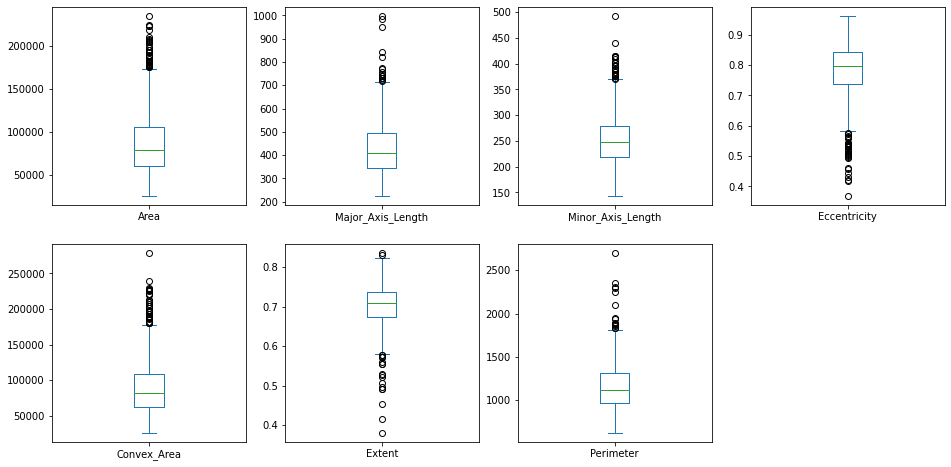

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

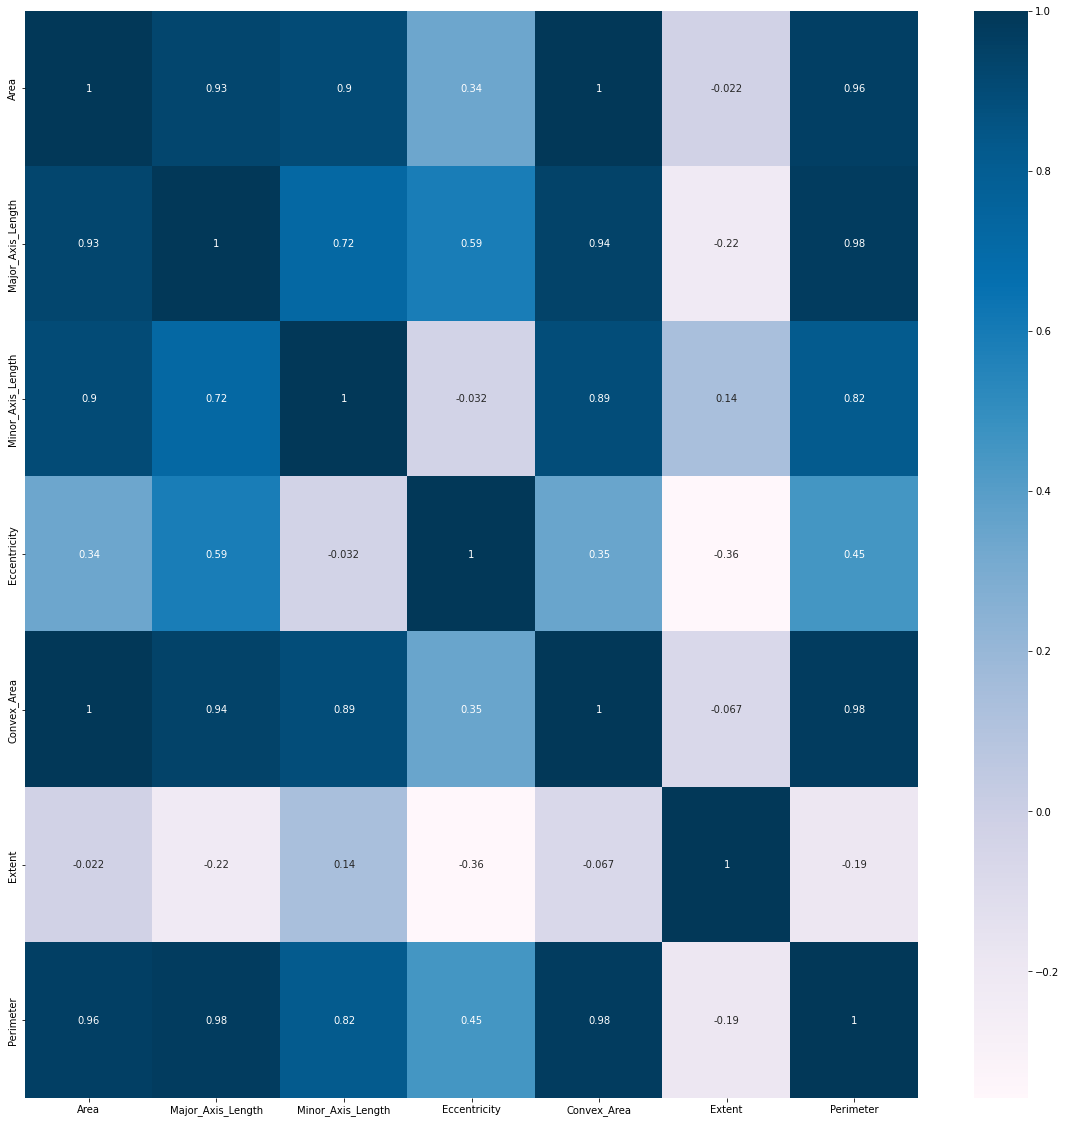

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [28]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [29]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpo3la40tk as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:10.995855
Training model
Model trained in 0:00:00.676170
Compiling model
1/1 [==============================] - 12s 12s/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model training time: 0:00:14.162755 



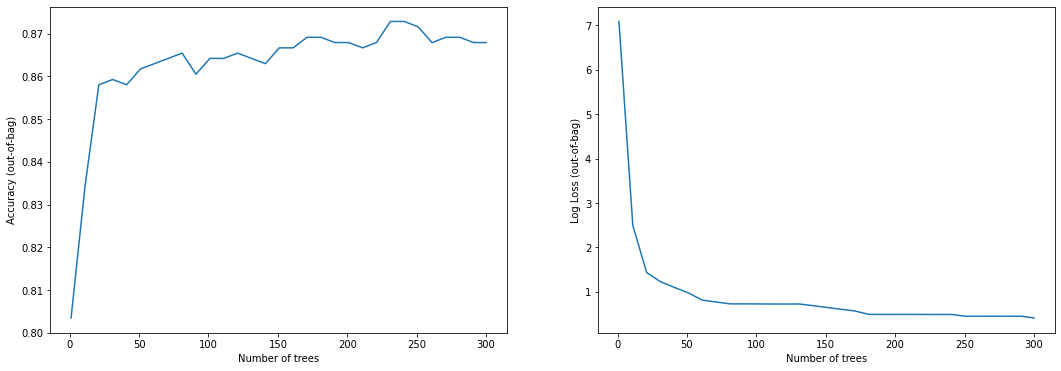

In [30]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [31]:
RF_eval = RF_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 674ms/step - loss: 0.0000e+00 - accuracy: 0.9605 - auc: 0.9942

loss: 0.0000
accuracy: 0.9605
auc: 0.9942


### 3.c) Train and Evaluate the Decision Trees Model

In [32]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp4kt4916r as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.266969
Training model
Model trained in 0:00:00.006647
Compiling model
1/1 [==============================] - 0s 279ms/step
Model training time: 0:00:00.453884 



In [33]:
CART_eval = CART_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 373ms/step - loss: 0.0000e+00 - accuracy: 0.8864 - auc: 0.9634

loss: 0.0000
accuracy: 0.8864
auc: 0.9634


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [34]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp6oxfmss4 as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.133283
Training model
Model trained in 0:00:00.215542
Compiling model
1/1 [==============================] - 0s 356ms/step
Model training time: 0:00:00.501160 



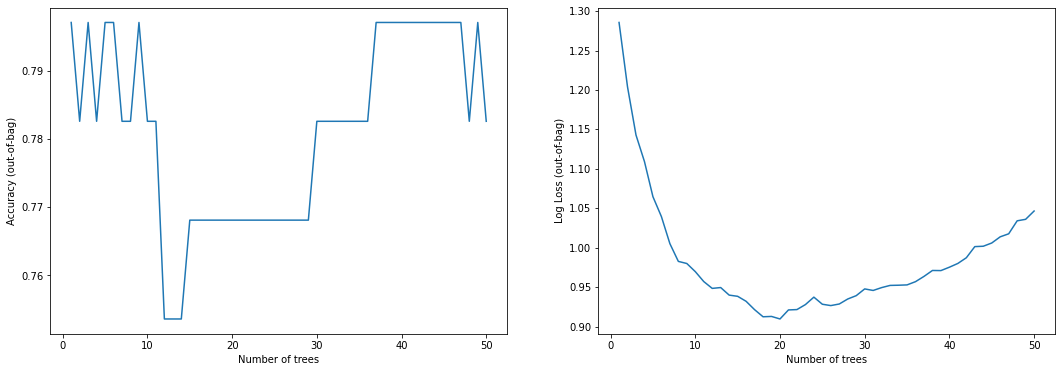

In [35]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [36]:
GBT_eval = GBT_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 388ms/step - loss: 0.0000e+00 - accuracy: 0.9272 - auc: 0.9670

loss: 0.0000
accuracy: 0.9272
auc: 0.9670


In [37]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [39]:
# Not applicable for this iteration of modeling

In [40]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [41]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [42]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpw119uine as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.120628
Training model
Model trained in 0:00:00.398514
Compiling model
1/1 [==============================] - 1s 583ms/step
Model training time: 0:00:00.735158 



In [43]:
Final_model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	Area
	Convex_Area
	Eccentricity
	Extent
	Major_Axis_Length
	Minor_Axis_Length
	Perimeter

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  7.549010 ################
    2. "Minor_Axis_Length"  5.749420 ###########
    3.              "Area"  5.102723 #########
    4.            "Extent"  4.620530 ########
    5.       "Convex_Area"  4.580192 #######
    6.      "Eccentricity"  4.451233 #######
    7. "Major_Axis_Length"  1.969185 
    8.         "Perimeter"  1.627950 

Variable Importance: NUM_AS_ROOT:
    1. "Major_Axis_Length" 132.000000 ################
    2.         "Perimeter" 122.000000 

### 5.b) Load Test Dataset and Make Predictions

In [44]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_test, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [45]:
Final_eval = Final_model.evaluate(tfds_test, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 371ms/step - loss: 0.0000e+00 - accuracy: 0.8667 - auc: 0.9670

loss: 0.0000
accuracy: 0.8667
auc: 0.9670


In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:00:25.589271
